In [55]:
# All of these (except TQDM) are standard imports and are included for example in Anaconda
# TQDM is a package for progress bars and can be easily installed, see https://pypi.org/project/tqdm/
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise_kernels
import scipy.linalg as lin
from scipy.special import zeta
from sklearn.decomposition import PCA
import pandas as pd
import sklearn.gaussian_process as gp
from scipy.stats import t
from scipy.stats import percentileofscore 
from tqdm import tqdm_notebook as tqdm
import os
import pandas as pd
import random
from matplotlib import image

# Norm Functions and T Maps

### The next two cells contain the code for the five different settings used in the numerical tests: ID, CEXP, FPCA, POLY and SQR. 

### To see how to combine these to recreate the numerical results see comments in the cells which perform the tests.

In [56]:
def K_ID(X,Y,gamma=1):
    """
    Forms the kernel matrix K for the two sample test using the SE-T kernel with bandwidth gamma
    where T is the identity operator
    
    Parameters:
    X - (n_samples,n_obs) array of samples from the first distribution 
    Y - (n_samples,n_obs) array of samples from the second distribution 
    gamma - bandwidth for the kernel, if -1 then median heuristic is used to pick gamma
    
    Returns:
    K - matrix formed from the kernel values of all pairs of samples from the two distributions
    """
    n_obs = X.shape[1]
    XY = np.vstack((X,Y))
    dist_mat = (1/np.sqrt(n_obs))*pairwise_distances(XY, metric='euclidean')
    if gamma == -1:
        gamma = np.median(dist_mat[dist_mat > 0])
   
    K = np.exp(-0.5*(1/gamma**2)*(dist_mat**2))
    return K

def FPCA(X,n_comp = 0.95):
    """
    Computes principal components of given data up to a specified explained variance level
    
    Parameters:
    X - (n_samples,n_obs) array of function values
    n_comp - number of principal components to compute. If in (0,1) then it is the explained variance level
    
    Returns:
    Normalised eigenvalues and eigenfunctions
    """
    n_points = np.shape(X)[1]
    pca = PCA(n_components = n_comp)
    pca.fit(X)
    return (1/n_points)*pca.explained_variance_,pca.components_

def K_COV(X,Y,gamma=1):
    """
    Forms the kernel matrix K for the two sample test using the COV kernel
    
    Parameters:
    X - (n_samples,n_obs) array of samples from the first distribution 
    Y - (n_samples,n_obs) array of samples from the second distribution 
    gamma - dummy variable noot used in function, is an input for ease of compatability with other kernels
    
    Returns:
    K - matrix formed from the kernel values of all pairs of samples from the two distributions
    """    
    n_obs = X.shape[1]
    XY = np.vstack((X,Y))
    return ((1/n_obs)*np.dot(XY,XY.T))**2


def K_FPCA(X,Y,gamma = 1,n_comp = 0.95):
    """
    Forms the kernel matrix K for the two sample test using the SE-T kernel with bandwidth gamma
    where T is the FPCA decomposition operator
    
    Parameters:
    X - (n_samples,n_obs) array of samples from the first distribution 
    Y - (n_samples,n_obs) array of samples from the second distribution 
    gamma - bandwidth for the kernel, if -1 then median heuristic is used to pick gamma
    n_comp - number of principal components to compute. If in (0,1) then it is the explained variance level
    
    Returns:
    K - matrix formed from the kernel values of all pairs of samples from the two distributions
    """
    n_obs = X.shape[1]
    XY = np.vstack((X,Y))
    e_vals,e_funcs = FPCA(XY,n_comp = n_comp)
    scaled_e_funcs = e_funcs*np.sqrt(e_vals[:,np.newaxis])
    XY_e = (1/n_obs)*np.dot(XY,scaled_e_funcs.T)
    dist_mat = pairwise_distances(XY_e,metric='euclidean')
    if gamma == -1:
        gamma = np.median(dist_mat[dist_mat > 0])
    K = np.exp(-0.5*(1/gamma**2)*(dist_mat**2))
    return K

def K_SQR(X,Y,gamma = 1):
    """
    Forms the kernel matrix K for the two sample test using the SE-T kernel with bandwidth gamma
    where T is the map which sends x -> (x,x^{2}) in the Cartesian product of L^{2} with itself.
    
    Parameters:
    X - (n_samples,n_obs) array of samples from the first distribution 
    Y - (n_samples,n_obs) array of samples from the second distribution 
    gamma - bandwidth for the kernel to be used on the two norms, if -1 then median heuristic 
            is used to pick a different gamma for each norm, if gamma = 0 then median heuristic
            is used to pick a single gamma for each norm.
            
    Returns:
    K - matrix formed from the kernel values of all pairs of samples from the two distributions
    """
    n_obs = X.shape[1]
    XY = np.vstack((X,Y))
    dist_mat_1 = (1/np.sqrt(n_obs))*pairwise_distances(XY, metric='euclidean')
    dist_mat_2 = (1/np.sqrt(n_obs))*pairwise_distances(XY**2, metric='euclidean')
    dist_mat = dist_mat_1 + dist_mat_2
    if gamma == 0:
        gamma = np.median(dist_mat[dist_mat > 0])
        K = np.exp(-0.5*(1/gamma**2)*dist_mat**2)
        return K
    if gamma == -1:
        gamma_1 = np.median(dist_mat_1[dist_mat_1 > 0])
        gamma_2 = np.median(dist_mat_2[dist_mat_2 > 0])
        K = np.exp(-0.5*((1/gamma_1**2)*dist_mat_1**2 + (1/gamma_2**2)*dist_mat_2**2))
        return K
    K = np.exp(-0.5*((1/gamma**2)*(dist_mat**2)))
    return K


In [57]:
def cos_exp_kernel(x,y,n_freqs = 5,l=1):
    """
    The c-exp kernel
    
    Parameters:
    x,y - inputs 
    n_freqs - number of frequencies to include in the sum
    l- bandwidth of the kernel
    
    Returns:
    Kernel values given x,y
    """
    
    cos_term = np.sum([np.cos(2*np.pi*n*(x-y)) for n in range(n_freqs)])
    return cos_term*np.exp(-(0.5/(l**2))*(x-y)**2)

def CEXP(X,n_freqs = 20,l=np.sqrt(10)):
    """
    Transforms an array of function values using the integral operator induced by the cos-exp kernel. 
    The function values are assumed to be on [0,1]
    
    Parameters:
    X - (n_samples,n_obs) array of function values
    n_freqs - number of frequencies to include in the sum
    l- bandwidth of the kernel
    
    Returns:
    cos_exp_X - (n_samples,n_obs) array of function values where each function has been passed
                through the integral operator induced by the cos-exp kernel
    """
    n_obs = X.shape[1]
    obs_grid = np.linspace(0,1,n_obs)
    T_mat = pairwise_kernels(obs_grid.reshape(-1,1), metric = cos_exp_kernel, n_freqs = n_freqs,l=l)
    cos_exp_X = (1./n_obs)*np.dot(X,T_mat)
    return cos_exp_X

# Testing Functions

### The next three cells contain the functions used to conduct the two sample test.

### MMD_K calculates an empirical MMD quantity 

### two_sample_test performs a two-sample test, using MMD_K multiple times

### power_test performs two_sample_test numerous times to calculate an estimate of test power

In [58]:
def MMD_K(K,M,N):
    """
    Calculates the empirical MMD^{2} given a kernel matrix computed from the samples and the sample sizes of each distribution.
    
    Parameters:
    K - kernel matrix of all pairwise kernel values of the two distributions
    M - number of samples from first distribution
    N - number of samples from first distribution
    
    Returns:
    MMDsquared - empirical estimate of MMD^{2}
    """
    
    Kxx = K[:N,:N]
    Kyy = K[N:,N:]
    Kxy = K[:N,N:]
    
    t1 = (1./(M*(M-1)))*np.sum(Kxx - np.diag(np.diagonal(Kxx)))
    t2 = (2./(M*N)) * np.sum(Kxy)
    t3 = (1./(N*(N-1)))* np.sum(Kyy - np.diag(np.diagonal(Kyy)))
    
    MMDsquared = (t1-t2+t3)
    
    return MMDsquared

In [59]:
def two_sample_test(X,Y,gamma,n_perms,z_alpha = 0.05,make_K = K_ID,return_p = False):
    """
    Performs the two sample test and returns an accept or reject statement
    
    Parameters:
    X - (n_samples,n_obs) array of samples from the first distribution 
    Y - (n_samples,n_obs) array of samples from the second distribution 
    gamma - bandwidth for the kernel
    n_perms - number of permutations performed when bootstrapping the null
    z_alpha - rejection threshold of the test
    return_p - option to return the p-value of the test
    make_K - function called to construct the kernel matrix used to compute the empirical MMD
    
    Returns:
    rej - 1 if null rejected, 0 if null accepted
    p-value - p_value of test
    
    """
    
    # Number of samples of each distribution is identified and kernel matrix formed
    M = X.shape[0]
    N = Y.shape[0]
    K = make_K(X,Y,gamma = gamma)
    
    # Empirical MMD^{2} calculated
    MMD_test = MMD_K(K,M,N)
    
    # For n_perms repeats the kernel matrix is shuffled and empirical MMD^{2} recomputed
    # to simulate the null
    shuffled_tests = np.zeros(n_perms)
    for i in range(n_perms):
            idx = np.random.permutation(M+N)
            K = K[idx, idx[:, None]]
            shuffled_tests[i] = MMD_K(K,M,N)
    
    # Threshold of the null calculated and test is rejected if empirical MMD^{2} of the data
    # is larger than the threshold
    q = np.quantile(shuffled_tests, 1.0-z_alpha)
    rej = int(MMD_test > q)
    
    if return_p:
        p_value = 1-(percentileofscore(shuffled_tests,MMD_test)/100)
        return rej, p_value
    else:
        return rej

In [60]:
def power_test(X_samples,Y_samples,gamma,n_tests,n_perms,z_alpha = 0.05,make_K = K_ID,return_p = False):
    """
    Computes multiple two-sample tests and returns the rejection rate
    
    Parameters:
    X_samples - (n_samples*n_tests,n_obs) array of samples from the first distribution 
    Y_samples - (n_samples*n_tests,n_obs) array of samples from the second distribution 
    gamma - bandwidth for the kernel
    n_tests - number of tests to perform
    n_perms - number of permutations performed when bootstrapping the null
    z_alpha - rejection threshold of the test
    make_K - function called to construct the kernel matrix used to compute the empirical MMD
    return_p - option to return the p-value of the test
    
    Returns:
    power - the rate of rejection of the null
    """
    
    # Number of samples of each distribution is identified
    M = int(X_samples.shape[0]/n_tests)
    N = int(Y_samples.shape[0]/n_tests)
    rej = np.zeros(n_tests)
    
    # For each test, extract the data to use and then perform the two-sample test
    for t in tqdm(range(n_tests)):
        X_t = X_samples[t*M:(t+1)*M,:]
        Y_t = Y_samples[t*N:(t+1)*N,:]
        rej[t] = two_sample_test(X_t,Y_t,gamma,n_perms,z_alpha = z_alpha,make_K = make_K,return_p = return_p)
    
    # Compute average rate of rejection
    power = np.mean(rej)
    return power

# Power scaling of i.i.d noise versus correlated noise

### Samples of multivariate Gaussians are created for different covariance matrices constructed from the Gaussian kernel with different bandwidths. For different dimensions and different bandwidths the power of the two-sample test is computed. 

In [61]:
def K_l2(X,Y,gamma=1):
    """
    Forms the kernel matrix K for the two sample test using the standard Gaussian kernel with Euclidean norm
    with bandwidth gamma
    
    Parameters:
    X - (n_samples,n_obs) array of samples from the first distribution 
    Y - (n_samples,n_obs) array of samples from the second distribution 
    gamma - bandwidth for the Gaussian kernel, if -1 then median heuristic is used to pick gamma
    
    Returns:
    K - matrix formed from the kernel value of all pairs of samples from the two distributions
    """
    XY = np.vstack((X,Y))
    dist_mat = pairwise_distances(XY, metric='euclidean')
    if gamma == -1:
        gamma = np.median(dist_mat[dist_mat > 0])
    K = np.exp(-0.5*(1/gamma**2)*(dist_mat**2))
    return K

In [64]:
# Random state is initialised for reproducibility and the arrays containing the dimensions
# and square of bandwidthlengthscales is initialised
rng = np.random.RandomState(1234)
sub_d_arr = np.array([100,200,400,800,1600])
l_sqr_arr = np.array([0,0.0005,0.001,0.002,0.004,0.008])

# Number of tests to calculate power, number of permutations for the bootstrap and number of samples from
# each distribution for each test
n_tests = 500
n_perms = 1000
M = 50
N = 50

# Generating the data to be used for the tests. Data has identity covariance which will be transformed by 
# multiplication with a matrix for the different bandwidths
max_d = np.max(sub_d_arr)
X = rng.normal(0,1,(n_tests*M,max_d))
Y = rng.normal(0,1,(n_tests*N,max_d)) 
m = 0.05
mu = m*np.ones(max_d)
Y_shift = Y + mu

In [65]:
powers = np.zeros((len(l_sqr_arr),len(sub_d_arr)))
for i,l_sqr in enumerate(tqdm(l_sqr_arr)):
    for j,sub_d in enumerate(sub_d_arr):
        # Sets the bandwidth
        gamma = np.sqrt(sub_d)
        
        # l = 0 corresponds to i.i.d. data so no multiplication to change the covariance needed
        if l_sqr == 0:
            powers[i,j] = power_test(X[:,:sub_d],Y_shift[:,:sub_d],gamma,n_tests,n_perms,make_K = K_l2)
        else:
            # Constructs the square root of the covariance matrix for the given bandwidth
            xd = np.linspace(0,1,sub_d)
            sqrt_exp_mat = lin.sqrtm(np.exp(-(1/(2*l_sqr))*pairwise_distances(xd[:,np.newaxis])))
            
            # Create correlated samples by matrix multiplication
            X_corr = np.dot(X[:,:sub_d],sqrt_exp_mat)
            Y_corr = np.dot(Y[:,:sub_d],sqrt_exp_mat)
            Y_corr_shift = Y_corr + mu[:sub_d]
            powers[i,j] = power_test(X_corr,Y_corr_shift,gamma,n_tests,n_perms,make_K = K_l2)

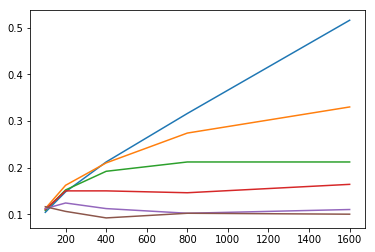

In [66]:
plt.plot(sub_d_arr,powers.T)

# Synthetic Mean Shift Data

### Data is from Scenario A). of Section 4.1 of "A Two Sample Distribution-Free Test for Functional Data with Application to a Diffusion Tensor Imaging Study of Multiple Sclerosis" by Pomann et al, JRSSB 2016

In [7]:
def mean_shift(n_samples,obs_grid,delta = 0,sd = np.sqrt(0.25),random_state = None):
    """
    Data used for the mean shift test. 
    
    Parameters:
    n_samples - number of function samples to return
    obs_grid - observation locations 
    delta - the coefficient of t^3
    sd - the standard deviation of the observation noise
    random_state - random seed
    
    """
    rng = np.random.RandomState(random_state)
    n_points = len(obs_grid)
    X = (rng.normal(0,np.sqrt(10),(n_samples,1))*np.sqrt(2)*np.sin(2*np.pi*obs_grid)) + (rng.normal(0,np.sqrt(5),(n_samples,1))*np.sqrt(2)*np.cos(2*np.pi*obs_grid))
    X += obs_grid + delta*(obs_grid**3)
    X += rng.normal(0,sd,(n_samples,n_points))
    return X

In [10]:
# Set random seed
rng_X = 1234
rng_Y = 5678

# Number of tests and permutations for the bootstrap per test
n_tests = 500
n_perms = 1000

# Samples sizes for the two distributions
M = 100
N = 100

# Range of parameters to test over
delta_arr = np.array([0,0.5,1,1.5,2])

# Grid of observation locations
n_grid_points = 100
obs_grid = np.linspace(0,1,n_grid_points)

# Set bandwidth parameter, -1 causes median heuristic to be used
gamma = -1

In [15]:
mean_shift_powers = np.zeros(len(delta_arr)) 

# Loop over delta values
for i,delta in enumerate(tqdm(delta_arr)):
    # Generate the data
    X = mean_shift(M*n_tests,obs_grid,delta = 0,sd = np.sqrt(0.25),random_state = rng_X)
    Y = mean_shift(N*n_tests,obs_grid,delta = delta,sd = np.sqrt(0.25),random_state = rng_Y)
    
    # For each of the different scenarios ID, FPCA, SQR, CEXP, POLY alter the code as follows:
    # ID: Use K_ID in power_test
    # FPCA: Use K_FPCA in power_test
    # SQR: Use K_SQR in power_test
    # COV: Use K_COV in power_test
    # CEXP: Run the following lines before using K_ID in power_test, for given values of n_freqs and l
#     n_freqs = 20
#     l = np.sqrt(10)
#     X = CEXP(X,n_freqs,l) 
#     Y = CEXP(Y,n_freqs,l) 

    
    # Calculate and store power for this choice the delta
    mean_shift_powers[i] = power_test(X,Y,gamma,n_tests,n_perms,make_K = K_COV)
    print(delta, mean_shift_powers[i])

0.0 0.048


0.5 0.044


1.0 0.042


1.5 0.044


2.0 0.064


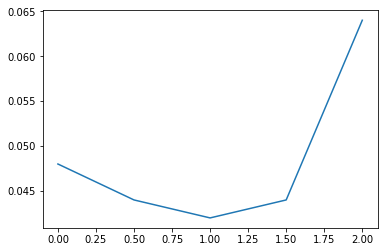

In [16]:
plt.plot(delta_arr,mean_shift_powers)

# Plotting ROC curve

In [48]:
alpha_arr = np.linspace(0,0.9,10)+0.05
N = 50
ROC_powers = np.zeros(len(alpha_arr))

for i,alpha in enumerate(tqdm(alpha_arr)):
    # Generate the data
    X = mean_shift(N*n_tests,obs_grid,delta = 0,sd = np.sqrt(0.25),random_state = rng_X)
    Y = mean_shift(N*n_tests,obs_grid,delta = 1.25,sd = np.sqrt(0.25),random_state = rng_Y)
    
    # For each of the different scenarios ID, FPCA, SQR, CEXP, POLY alter the code as follows:
    # ID: Use K_ID in power_test
    # FPCA: Use K_FPCA in power_test
    # SQR: Use K_SQR in power_test
    # COV: Use K_COV in power_test
    # CEXP: Run the following lines before using K_ID in power_test, for given values of n_freqs and l
#     n_freqs = 20
#     l = np.sqrt(10)
#     X = CEXP(X,n_freqs=20,l=np.sqrt(10)) 
#     Y = CEXP(Y,n_freqs=20,l=np.sqrt(10)) 

    
    
    # Calculate and store power for this choice the delta
    ROC_powers[i] = power_test(X,Y,gamma,n_tests,n_perms,make_K = K_COV,z_alpha = alpha)
    print('alpha: ',alpha, ' True positive rate rate: ', ROC_powers[i])

alpha:  0.05  True positive rate rate:  0.072


alpha:  0.15000000000000002  True positive rate rate:  0.154


alpha:  0.25  True positive rate rate:  0.252


alpha:  0.35000000000000003  True positive rate rate:  0.38


alpha:  0.45  True positive rate rate:  0.478


alpha:  0.55  True positive rate rate:  0.58


alpha:  0.6500000000000001  True positive rate rate:  0.688


alpha:  0.7500000000000001  True positive rate rate:  0.774


alpha:  0.8500000000000001  True positive rate rate:  0.86


alpha:  0.9500000000000001  True positive rate rate:  0.946


# Synthetic Variance Shift Data, Shift in Single Frequency

### Data is from Scenario B). of Section 4.1 of "A Two Sample Distribution-Free Test for Functional Data with Application to a Diffusion Tensor Imaging Study of Multiple Sclerosis" by Pomann et al, JRSSB 2016

In [17]:
def variance_shift_single_freq(n_samples,obs_grid,delta = 0, sd = np.sqrt(0.25),random_state = None):
    """
    Data used for the single frequency variance shift test. 
    
    Parameters:
    n_samples - number of function samples to return
    obs_grid - observation locations 
    delta - the coefficient of t^3
    sd - the standard deviation of the observation noise
    random_state - random seed
    
    """
    rng = np.random.RandomState(random_state)
    n_points = len(obs_grid)
    X = (rng.normal(0,np.sqrt(10+delta),(n_samples,1))*np.sqrt(2)*np.sin(2*np.pi*obs_grid)) + (rng.normal(0,np.sqrt(5),(n_samples,1))*np.sqrt(2)*np.cos(2*np.pi*obs_grid))
    X += rng.normal(0,sd,(n_samples,n_points))
    return X

In [18]:
# Set random seed
rng_X = 1234
rng_Y = 5678

# Number of tests and permutations for the bootstrap per test
n_tests = 500
n_perms = 1000


# Samples sizes for the two distributions
M = 100
N = 100

# Range of parameters to test over
delta_arr = np.array([0,5,10,15,20])

# Grid of observation locations
n_grid_points = 100
obs_grid = np.linspace(0,1,n_grid_points)

# Set bandwidth parameter, -1 causes median heuristic to be used
gamma = -1

In [23]:
var_shift_powers = np.zeros(len(delta_arr)) 
# Loop over delta values
for i,delta in enumerate(tqdm(delta_arr)):
    # Generate the data
    X = variance_shift_single_freq(M*n_tests,obs_grid,delta = 0,sd = np.sqrt(0.25),random_state = rng_X)
    Y = variance_shift_single_freq(N*n_tests,obs_grid,delta = delta,sd = np.sqrt(0.25),random_state = rng_Y)
    
    # For each of the different scenarios ID, FPCA, SQR, CEXP, POLY alter the code as follows:
    # ID: Use K_ID in power_test
    # FPCA: Use K_FPCA in power_test
    # SQR: Use K_SQR in power_test
    # COV: Use K_COV in power_test
    # CEXP: Run the two following lines before using K_ID in power_test, for given values of n_freqs and l
#     n_freqs = 20
#     l = np.sqrt(10)
#     X = CEXP(X,n_freqs,l) 
#     Y = CEXP(Y,n_freqs,l) 

    
    # Calculate and store power for this choice the delta
    var_shift_powers[i] = power_test(X,Y,gamma,n_tests,n_perms,make_K = K_COV)
    print(delta, var_shift_powers[i])

0 0.05


5 0.484


10 0.93


15 0.992


20 1.0


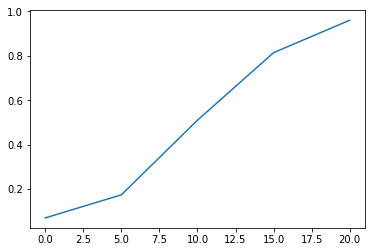

In [40]:
plt.plot(delta_arr,var_shift_powers)

# Synthetic Variance Shift Data, Scalar Difference on all Frequencies

### Data is from Section 3.1 of "Bootstrap-based testing of equality of mean functions or equality of covariance operators for functional data" by Paparoditis and Sapatinas, Biometrika 2016

In [24]:
def variance_scalar_difference(n_samples,obs_grid,delta = 1,random_state = None):
    """
    Data used for the sclar multiple difference variance test. 
    
    Parameters:
    n_samples - number of function samples to return
    obs_grid - observation locations 
    delta - the scalar which the function is multiplied by
    random_state - random seed
    
    """
    rng = np.random.RandomState(random_state)
    n_obs = len(obs_grid)
    t_vals = t.rvs(df = 5,size = (n_samples,2),random_state = rng)
    n_points = len(obs_grid)
    X = np.zeros((n_samples,n_obs))
    for i in range(n_samples):
        X[i,:] = np.sum([np.sqrt(2)*(k**(-0.5))*np.sin(np.pi*k*obs_grid)*t_vals[i,0] + (k**(-0.5))*np.cos(np.pi*k*obs_grid)*t_vals[i,1] for k in range(1,11)],axis=0)
    return delta*X

In [25]:
# Set random seed
rng_X = 1234
rng_Y = 5678

# Number of tests and permutations for the bootstrap per test
n_tests = 500
n_perms = 1000

# Samples sizes for the two distributions
M = 25
N = 25

# Range of parameters to test over
delta_arr = np.array([1,1.2,1.4,1.6,1.8,2])

# Grid of observation locations
n_grid_points = 500
obs_grid = np.linspace(0,1,n_grid_points)

# Set bandwidth parameter, -1 causes median heuristic to be used
gamma = -1

In [31]:
var_shift_powers = np.zeros(len(delta_arr))

# Loop over delta values
for i,delta in enumerate(tqdm(delta_arr)):
    # Generate the data
    X = variance_scalar_difference(M*n_tests,obs_grid,random_state = rng_X)
    Y = variance_scalar_difference(N*n_tests,obs_grid,delta = delta,random_state = rng_Y)
    
    # For each of the different scenarios ID, FPCA, SQR, CEXP, POLY alter the code as follows:
    # ID: Use K_ID in power_test
    # FPCA: Use K_FPCA in power_test
    # SQR: Use K_SQR in power_test
    # COV: Use K_COV in power_test
    # CEXP: Run the following lines before using K_ID in power_test, for given values of n_freqs and l
#     n_freqs = 20
#     l = np.sqrt(10)
#     X = CEXP(X,n_freqs,l) 
#     Y = CEXP(Y,n_freqs,l) 

    
    # Calculate and store power for this choice the delta
    var_shift_powers[i] = power_test(X,Y,gamma,n_tests,n_perms,make_K = K_COV)
    print(delta, var_shift_powers[i])

1.0 0.05


1.2 0.11


1.4 0.264


1.6 0.47


1.8 0.632


2.0 0.764


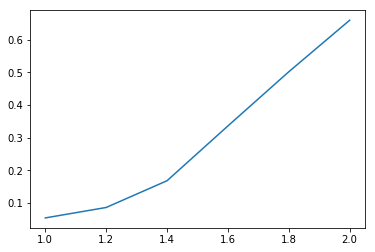

In [48]:
plt.plot(delta_arr,var_shift_powers)

# Synthetic Higher Order Differences Data

### Data is from Section 3.1 of "Two-sample tests in functional data analysis starting from discrete data" by Hall and Van Keilegom, Statistica Sinica 2007

In [32]:
def higher_order_difference(n_samples,n_obs,delta = 1,sd = 0.1,uniform_samp = True,random_state = None):
    """
    Higher order difference data is generated, including the random observation points sampling.
    
    Parameters:
    n_samples - number of function samples to return
    n_obs - number of observations per function sample 
    delta - the scalar which determines the deviation from the null
    sd - standard deviation of observation noise
    uniform_samp - Parameter to decide which random point sampling procedure to use for each function sample
                     True is random uniform sampling on [0,1] 
                     False is random sampling using the density p(t) = 0.8 + 0.4*t on [0,1]
    random_state - random seed
    
    Returns:
    X - the generated random functions
    obs_grid - observation point locations for each random function
    
    """
    rng = np.random.RandomState(random_state)
    obs_grid = point_sample(n_samples,n_obs,uniform_samp=uniform_samp,random_state = random_state)
    X = np.zeros((n_samples,n_obs))
    for i,obs in enumerate(obs_grid):
        rvs_1 = rng.normal(0,1,15)
        rvs_2 = rng.normal(0,1,15)
        X[i,:] = np.ones(n_obs)*(np.exp(-1/2)*rvs_1[0] + delta*rvs_2[0])
        for k in range(2,16):
            X[i,:] += np.exp(-k/2)*rvs_1[k-1]*np.sqrt(2)*np.sin((k-1)*np.pi*obs)
            if k % 2 ==0:
                X[i,:] += delta*(k**-2)*rvs_2[k-1]*np.sqrt(2)*np.cos((k-1)*np.pi*(2*obs - 1))
            else:
                X[i,:] += delta*(k**-2)*rvs_2[k-1]*np.sqrt(2)*np.sin((k-1)*np.pi*(2*obs - 1))
        X[i,:] += rng.normal(0,sd,n_obs)
    return X,obs_grid
        

def point_sample(n_samples,n_obs,uniform_samp = True,random_state = None):
    """
    Random samples the observation points for each function sample
    
    Parameters:
    n_samples - number of function samples
    n_obs - number of observations per function sample
    uniform_samp - Parameter to decide which random point sampling procedure to use for each function sample
                     True is random uniform sampling on [0,1] 
                     False is random sampling using the density p(t) = 0.8 + 0.4*t on [0,1]
    random_state - random seed
    
    Returns:
    obs_points - observation point locations for each random function
    
    """
    rng = np.random.RandomState(random_state)
    if n_samples > 1:
        obs_grid = rng.uniform(0,1,(n_samples,n_obs))
    else:
        obs_grid = rng.uniform(0,1,n_samples).reshape(-1,1)
    if uniform_samp:
        obs_grid.sort(axis=1)
        return obs_grid
    else:
        obs_grid = np.sqrt(4 + 5*obs_grid)-2
        obs_grid.sort(axis=1)
        return obs_grid

### The next two cells are the code to fit curves (specifically Gaussian processes) to the observed functions and then obtain function values of the fitted curves from a regular grid of points. A Matern kernel is used 

In [33]:
def GP_regression_single_sample(X,obs_grid,pred_grid,nu = 1.5,alpha = 1):
    """
    Given a single sample of functional data X at locations obs_grid, a GP is fit and predictions are
    given at locations pred_grid
    
    X - single function sample
    obs_grid - function sample observation locations
    pred_grid - prediction locations
    nu - Matern kernel smoothness parameter
    alpha - smoothness penalty
    
    Returns:
    The predictions of a Matern GP with parameters mu, alpha, at locations pred_grid
    """
    kernel = gp.kernels.Matern(nu = nu)
    GP = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=0, alpha=alpha,optimizer = None)
    GP.fit(obs_grid, X)
    return GP.predict(pred_grid)

def GP_regression_multi_sample(X,obs_grid,pred_grid, nu = 1.5,alpha = 1):
    """
    Given a multiple samples of functional data X, an array of corresponding observation locations obs_grid, 
    a GP is fit and predictions are given at locations pred_grid
    
    X - multiple function samples
    obs_grid - function samples observation locations
    pred_grid - prediction locations
    nu - Matern kernel smoothness parameter
    alpha - smoothness penalty
    
    Returns:
    The predictions of a Matern GP with parameters mu, alpha, at locations pred_grid
    """
    X_reg = np.zeros((X.shape[0],len(pred_grid)))
    for j in range(X.shape[0]):
        X_reg[j,:] = GP_regression_single_sample(X[j,:],obs_grid[j,:].reshape(-1,1),pred_grid,nu,alpha)
    return X_reg

In [37]:
# Set random seed
rng_X = 1234
rng_Y = 5678

# Number of tests and permutations for the bootstrap per test
n_tests = 500
n_perms = 1000

# Samples sizes for the two distributions
M = 15
N = 15

# Range of parameters to test over
delta_arr = np.array([0,1,2,3,4])

# Number of observation locations of each sample
n_obs = 20

# Grid of prediction points when fitting curves
n_preds = 100
# reshape is used so the dimensions are correct for when fitting curves with a GP
pred_grid = np.linspace(0,1,n_obs).reshape(-1,1)

# Set bandwidth parameter, -1 causes median heuristic to be used
gamma = -1

In [43]:
delta_powers = np.zeros(len(delta_arr))

for i,delta in enumerate(tqdm(delta_arr)):
    
    X,obs_grid_X = higher_order_difference(M*n_tests,n_obs,delta = 0,sd = 0.1,uniform_samp=True,random_state = rng_X)
    Y,obs_grid_Y = higher_order_difference(N*n_tests,n_obs,delta = delta,sd = 0.3,uniform_samp=False,random_state = rng_Y)
    X = GP_regression_multi_sample(X,obs_grid_X,pred_grid,nu = 1.5,alpha = 0.001)
    Y = GP_regression_multi_sample(Y,obs_grid_Y,pred_grid,nu = 1.5,alpha = 0.001)
    
    # For each of the different scenarios ID, FPCA, SQR, CEXP, POLY alter the code as follows:
    # ID: Use K_ID in power_test
    # FPCA: Use K_FPCA in power_test
    # SQR: Use K_SQR in power_test
    # COV: Use K_COV in power_test
    # CEXP: Run the following lines before using K_ID in power_test, for given values of n_freqs and l
#     n_freqs = 20
#     l = np.sqrt(10)
#     X = CEXP(X,n_freqs,l) 
#     Y = CEXP(Y,n_freqs,l) 

    
    delta_powers[i] = power_test(X,Y,gamma,n_tests,n_perms,make_K = K_COV)
    print(delta, delta_powers[i])

0 0.072


1 0.474


2 0.968


3 0.996


4 1.0


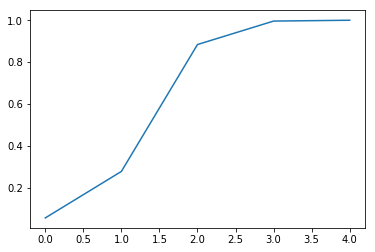

In [82]:
plt.plot(delta_arr,delta_powers)